In [2]:
import trimesh
import numpy as np
import pyvista as pv
import time
start_time = time.time()

# Load in the meshes
mesh1_path = r"C:\Users\Maxim\Documents\03 University\04 Msci Project\MastersProject\person_0.obj"  # Frame 1
mesh2_path = r"C:\Users\Maxim\Documents\03 University\04 Msci Project\MastersProject\person_1.obj"  # Frame 2
mesh1 = trimesh.load(mesh1_path)
mesh2 = trimesh.load(mesh2_path)

# Specify the target coordinates (x, y, z)
target_coordinates = np.array([0, 0, 0])

# Compute the current centroid of the mesh
current_centroid = mesh1.centroid

# Compute the translation vector needed to move the centroid to the target position
translation_vector1 = target_coordinates - mesh1.centroid
translation_vector2 = target_coordinates - mesh2.centroid


# Create a translation transformation matrix
translation_matrix1 = trimesh.transformations.translation_matrix(translation_vector1)
translation_matrix2 = trimesh.transformations.translation_matrix(translation_vector2)

# Apply the translation to the mesh
mesh1.apply_transform(translation_matrix1)
mesh2.apply_transform(translation_matrix2)

# Ensure both meshes have the same number of vertices
assert len(mesh1.vertices) == len(mesh2.vertices), "Meshes must have the same number of vertices!"

# Fix normals (optional, for consistent rendering)
mesh1.fix_normals()
mesh2.fix_normals()

# Rotate the mesh to align it
# Example: Rotate around X-axis by 90 degrees to make the body face the camera
rotation_matrix = trimesh.transformations.rotation_matrix(
    angle=np.radians(180),  # Rotate 90 degrees
    direction=[1, 0, 0],  # Rotate around the X-axis
    point=[0, 0, 0]  # Center of rotation
)
# Apply rotation to the mesh
mesh1.apply_transform(rotation_matrix)
mesh2.apply_transform(rotation_matrix)

verticies = []
visible_verticies = []

# Calculate the positional differences between corresponding vertices
positional_differences = mesh2.vertices - mesh1.vertices

# Assume FPS of 30, so time between frames is 1/30 seconds
fps = 30
delta_t = 1 / fps

# Calculate velocity (magnitude of displacement divided by delta_t)
velocities = np.linalg.norm(positional_differences, axis=1) / delta_t



# Determine direction: Positive or Negative based on displacement along a specific axis (e.g., Z-axis)
directions = np.sign(positional_differences[:, 2])  # Assuming Z-axis as vertical

# Combine direction and velocity
signed_velocities = directions * velocities

sensor_position = np.array([0, 1, 3])


for i in range (len(mesh1.vertices)):
    d = {
        "index": i,
        "position": mesh1.vertices[i],
        "visible": False,
        "velocityVector": positional_differences[i],
        "relativeV": 0,
        "realRelativeV":0
    }
    
    verticies.append(d)


# Perform raycasting for visibility
visible_verticies = []
origins = np.array([v["position"] + 1e-4 * (sensor_position - v["position"]) for v in verticies])
directions = np.array([sensor_position - v["position"] for v in verticies])
is_visible = ~mesh1.ray.intersects_any(origins, directions)
for i, v in enumerate(verticies):
    v["visible"] = is_visible[i]
    if is_visible[i]:
        visible_verticies.append(v)
        
       

fps = 30
delta_t = 1 / fps
# Calculate velocity relative to the sensor
relative_velocities = []

positions = np.array([v["position"] for v in visible_verticies])
velocities = np.array([v["velocityVector"] for v in visible_verticies])
los_vectors = (positions - sensor_position) / np.linalg.norm(positions - sensor_position, axis=1)[:, None]
relative_velocities = np.einsum('ij,ij->i', velocities, los_vectors) * np.linalg.norm(velocities, axis=1)
scaled_relative_velocities = relative_velocities / delta_t
for i, v in enumerate(visible_verticies):
    v["relativeV"] = relative_velocities[i]
    v["realRelativeV"] = scaled_relative_velocities[i]

# Calculate magnitude of each vertex velocity relative to sensor location
end_time = time.time() 
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")
print(visible_verticies[:5])

Execution time: 2.386145 seconds
[{'index': 16, 'position': TrackedArray([0.04119192, 0.67722212, 0.09499466]), 'visible': True, 'velocityVector': TrackedArray([ 0.00390333, -0.00787393,  0.01468807]), 'relativeV': -0.00023402238209961396, 'realRelativeV': -0.0070206714629884185}, {'index': 17, 'position': TrackedArray([0.04839321, 0.67616808, 0.08911266]), 'visible': True, 'velocityVector': TrackedArray([ 0.00366866, -0.00781099,  0.01440507]), 'relativeV': -0.00022485824160311298, 'realRelativeV': -0.0067457472480933894}, {'index': 18, 'position': TrackedArray([0.04649677, 0.66960238, 0.09180966]), 'visible': True, 'velocityVector': TrackedArray([ 0.00368009, -0.00778058,  0.01424107]), 'relativeV': -0.00021984089875399954, 'realRelativeV': -0.006595226962619986}, {'index': 27, 'position': TrackedArray([0.03931468, 0.67006313, 0.09640266]), 'visible': True, 'velocityVector': TrackedArray([ 0.00383635, -0.00785164,  0.01455007]), 'relativeV': -0.0002294312921490748, 'realRelativeV': -

In [3]:
import numpy as np

def bin_relative_velocities(vertex_data, num_bins=32):
    """
    Bins the magnitudes of relative velocities into spatial bins based on vertex positions.

    Parameters:
        vertex_data (list of dicts): A list of dictionaries, where each dictionary contains vertex information,
                                     including 'index', 'position', and 'relativeV'.
        num_bins (int): The number of spatial bins.

    Returns:
        bins (list): A list of bins, where each bin contains the indices and magnitudes of vertices in that bin.
    """
    indices = [v['index'] for v in vertex_data]
    positions = np.array([v['position'] for v in vertex_data])
    magnitudes = [v['realRelativeV'] for v in vertex_data]
    
    # Define the spatial bins
    min_coords = positions.min(axis=0)
    max_coords = positions.max(axis=0)
    
    # Split space into `num_bins` bins along each axis
    bin_edges = [
        np.linspace(min_coords[i], max_coords[i], int(np.sqrt(num_bins)) + 1)
        for i in range(2)
    ]
    print(bin_edges)
    
    # Initialize the bins
    bins = [[] for _ in range(num_bins)]
    
    # Assign each vertex to a spatial bin
    for idx, pos, mag in zip(indices, positions, magnitudes):
        bin_x = np.digitize(pos[0], bin_edges[0]) - 1
        bin_y = np.digitize(pos[1], bin_edges[1]) - 1
        
        bin_index = (
            bin_x * len(bin_edges[1]) 
            + bin_y 
        )
        
        if 0 <= bin_index < num_bins:
            bins[bin_index].append((idx, mag))
    
    return bins

def compute_mean_normalized_magnitudes(binned_velocities):
    num_bins = len(binned_velocities)
    mean_normalized_magnitudes = np.zeros(num_bins)
    
    all_magnitudes = [magnitude for bin_data in binned_velocities for _, magnitude in bin_data]
    
    if len(all_magnitudes) == 0:
        return mean_normalized_magnitudes
    
    min_magnitude = min(all_magnitudes)
    max_magnitude = max(all_magnitudes)
    range_magnitude = max_magnitude - min_magnitude
    
    normalize = lambda x: (x - min_magnitude) / range_magnitude if range_magnitude != 0 else 0
    
    for i, bin_data in enumerate(binned_velocities):
        if bin_data:
            normalized_magnitudes = [normalize(magnitude) for _, magnitude in bin_data]
            mean_normalized_magnitudes[i] = np.mean(normalized_magnitudes)
        
    return mean_normalized_magnitudes

# Example usage:
binned_velocities = bin_relative_velocities(visible_verticies, num_bins=32)
mean_magnitudes = compute_mean_normalized_magnitudes(binned_velocities)
print(mean_magnitudes)

[array([-0.26069136, -0.15387116, -0.04705096,  0.05976923,  0.16658943,
        0.27340962]), array([-0.92061485, -0.5807598 , -0.24090476,  0.09895029,  0.43880534,
        0.77866038])]
[0.7713809  0.60626414 0.61218576 0.3740877  0.50411712 0.
 0.7219936  0.60592654 0.61647819 0.58040708 0.40807595 0.
 0.         0.62593296 0.6228824  0.66197884 0.42846559 0.32625427
 0.76141446 0.6632485  0.6247478  0.46117336 0.46567703 0.
 0.80611735 0.67646661 0.6235935  0.18042354 0.45216001 0.
 0.         0.        ]


In [7]:
def bin_velocities(velocities):
    # 32 bins between -2 and +2 m/s 
    # total number of velocites in each bin, then normalise these values
    # return an array of size 32 of the normalised number of velocities in each bin.
    
    # Define bin edges
    bins = np.linspace(-2, 2, 33)  # 33 edges for 32 bins

    # Compute histogram (counts per bin)
    histogram, _ = np.histogram(velocities, bins=bins)

    # Normalize the histogram (convert counts to probabilities)
    normalized_histogram = histogram / np.sum(histogram) if np.sum(histogram) > 0 else histogram

    return normalized_histogram

visible_velocities = [item['realRelativeV'] for item in visible_verticies]
print(len(visible_velocities))
histo = bin_velocities(visible_velocities)
print(histo)


4977
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.73719108 0.26280892 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def display(singleTimeValue):

    # Step 1: Duplicate 250 times to get (250, 32)
    arr_250x32 = np.tile(singleTimeValue, (250, 1))
    print(arr_250x32)
    print(f"Shape of input values is {arr_250x32.shape}")

    # Step 2: Reshape to (32, 250)
    doppler_data = arr_250x32.T

    # Create an intensity map for the Doppler data
    plt.figure(figsize=(10, 6))
    plt.imshow(doppler_data, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Intensity')
    plt.title('Doppler Intensity Map')
    plt.xlabel('Time/Frequency Bins')
    plt.ylabel('Radial Velocity (m/s)')
    plt.tight_layout()
    plt.show()

display(histo)

NameError: name 'histo' is not defined

### Testing


(32, 250)
0.05378009924176758
[0.01566104 0.02855442 0.02134447 0.02379709 0.02589284 0.03427461
 0.02765277 0.04173666 0.02921434 0.05488607 0.0246105  0.0304059
 0.01928235 0.00613361 0.01145036 0.01341487 0.01762978 0.02220439
 0.02259553 0.03579548 0.02523064 0.05461193 0.02010807 0.0177625
 0.02737112 0.01437678 0.00490397 0.00598769 0.01668644 0.05161858
 0.02272249 0.00957656 0.01719441 0.02382884 0.02087514 0.00954592
 0.00660499 0.01775352 0.01462025 0.03699963 0.05545512 0.03228518
 0.00949756 0.0177948  0.03399475 0.03750837 0.0052091  0.02521904
 0.00777329 0.02327825 0.01814047 0.04721054 0.04330379 0.03693663
 0.01377288 0.03117812 0.01098088 0.00488638 0.02593351 0.01865399
 0.02302808 0.00796383 0.02039139 0.0042121  0.02877152 0.02223386
 0.01207905 0.01464455 0.0348096  0.01552781 0.02979089 0.01193547
 0.02803012 0.02855888 0.02874249 0.03224902 0.00738482 0.04954994
 0.01308521 0.02455397 0.01374528 0.00658306 0.0137828  0.02010418
 0.03963984 0.01215385 0.00678989 

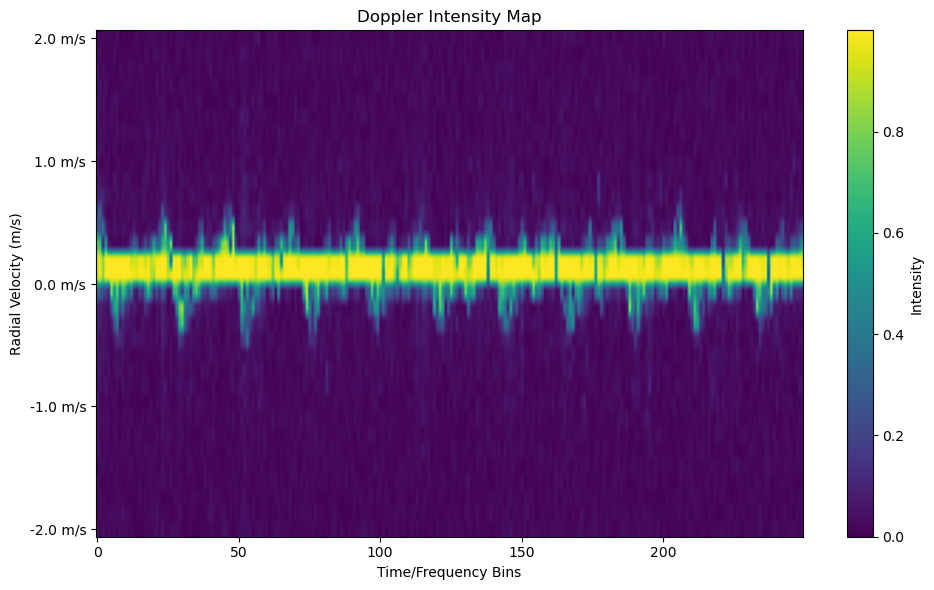

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Load the Doppler data
doppler_data_path = r"C:\Users\Maxim\Documents\03 University\04 Msci Project\Midas\doppler_data\radar_data\radar_data\dkk\0\01\doppler_gt.npy"  # Replace with the correct file path
#doppler_data_path = r"C:\Users\Maxim\OneDrive\Documents\03 University\02 Year5\01 Project\reconstructedDopplerData.npy"
doppler_data = np.load(doppler_data_path)
print(doppler_data.shape)
print(doppler_data[0].max())
print(doppler_data[1][:])


def get_spectograms(dop_dat, t_chunk, frames_per_sec, t_chunk_overlap=None, synthetic=False,zero_pad=False):
    frame_overlap = 1
    if t_chunk_overlap is not None:
        frame_overlap = int(t_chunk_overlap * frames_per_sec)
    frame_chunk = int(t_chunk * frames_per_sec)
    if zero_pad == True:
        zero_padding = np.zeros((32,frame_chunk-1))
        dop_dat_spec = np.hstack((zero_padding,np.transpose(dop_dat)))  
    else:
        dop_dat_spec = np.transpose(dop_dat)
    spectogram = []
    if zero_pad == True:
        for i in range(0,len(dop_dat), frame_overlap):
            spec = dop_dat_spec[:,i:i+frame_chunk]
            if synthetic == True:
                spec = cv2.GaussianBlur(spec,(5,5),0)
            spectogram.append(spec)
    else:
        for i in range(0,len(dop_dat)-frame_chunk, frame_overlap):
            spec = dop_dat_spec[:,i:i+frame_chunk]
            if synthetic == True:
                if zero_pad == True:
                    spec = cv2.GaussianBlur(spec,(5,5),0)
            spectogram.append(spec)
    spectogram = np.array(spectogram)
    return spectogram

#doppler_data = get_spectograms(doppler_data.T,3,24)



# Create an intensity map for the Doppler data
plt.figure(figsize=(10, 6))
plt.imshow(doppler_data, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Intensity')
plt.title('Doppler Intensity Map')
plt.xlabel('Time/Frequency Bins')
plt.ylabel('Radial Velocity (m/s)')

num_channels = doppler_data.shape[0]  # Number of sensor channels
y_ticks = np.linspace(0, num_channels - 1, 5)  # Select 5 tick positions
y_labels = np.linspace(-2, 2, 5)  # Corresponding velocity values (-2 to +2)
plt.yticks(y_ticks, [f"{label:.1f} m/s" for label in y_labels])  # Set labels
    
plt.tight_layout()
plt.show()


In [61]:
with alive_bar(1000) as bar:
    print(i)
    print(j)

TypeError: cannot unpack non-iterable int object

[[0.0, 0.0, 0.0, 0.0, 0.000630119722747322, 0.001890359168241966, 0.002520478890989288, 0.003780718336483932, 0.003990758244066373, 0.003990758244066373, 0.0058811174123083385, 0.005671077504725898, 0.005461037597143457, 0.00630119722747322, 0.00966183574879227, 0.24028565427431212, 0.6546943919344675, 0.04452846040747742, 0.010081915563957152, 0.000630119722747322, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6646531209957899, 0.16987003477942522, 0.1118433095368845, 0.032948929159802305, 0.020684605528098116, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Shape of input values is (2, 32)
<class 'numpy.ndarray'>


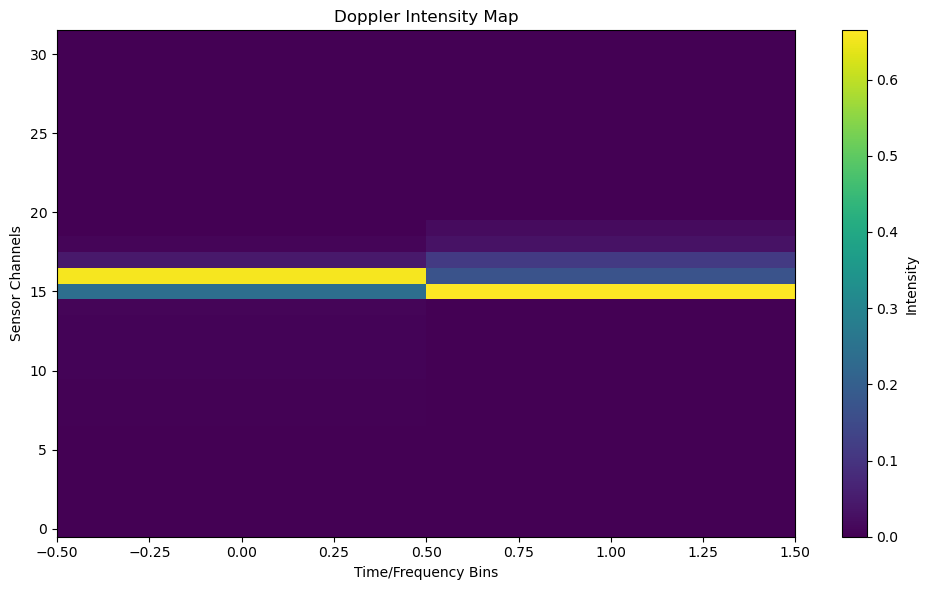

In [70]:
x = [[0.0, 0.0, 0.0, 0.0, 0.000630119722747322, 0.001890359168241966, 0.002520478890989288, 0.003780718336483932, 0.003990758244066373, 0.003990758244066373, 0.0058811174123083385, 0.005671077504725898, 0.005461037597143457, 0.00630119722747322, 0.00966183574879227, 0.24028565427431212, 0.6546943919344675, 0.04452846040747742, 0.010081915563957152, 0.000630119722747322, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6646531209957899, 0.16987003477942522, 0.1118433095368845, 0.032948929159802305, 0.020684605528098116, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
np.shape(x)

def display(values):
    print(values)
    print(f"Shape of input values is {np.shape(x)}")
    # Step 2: Reshape to (32, 250)
    doppler_data = np.array(values).T
    print(type(arr_250x32))

    # Create an intensity map for the Doppler data
    plt.figure(figsize=(10, 6))
    plt.imshow(doppler_data, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Intensity')
    plt.title('Doppler Intensity Map')
    plt.xlabel('Time/Frequency Bins')
    plt.ylabel('Sensor Channels')
    plt.tight_layout()
    plt.show()
    
display(x)

(32, 250)
0.05378009924176758
[0.01566104 0.02855442 0.02134447 0.02379709 0.02589284 0.03427461
 0.02765277 0.04173666 0.02921434 0.05488607 0.0246105  0.0304059
 0.01928235 0.00613361 0.01145036 0.01341487 0.01762978 0.02220439
 0.02259553 0.03579548 0.02523064 0.05461193 0.02010807 0.0177625
 0.02737112 0.01437678 0.00490397 0.00598769 0.01668644 0.05161858
 0.02272249 0.00957656 0.01719441 0.02382884 0.02087514 0.00954592
 0.00660499 0.01775352 0.01462025 0.03699963 0.05545512 0.03228518
 0.00949756 0.0177948  0.03399475 0.03750837 0.0052091  0.02521904
 0.00777329 0.02327825 0.01814047 0.04721054 0.04330379 0.03693663
 0.01377288 0.03117812 0.01098088 0.00488638 0.02593351 0.01865399
 0.02302808 0.00796383 0.02039139 0.0042121  0.02877152 0.02223386
 0.01207905 0.01464455 0.0348096  0.01552781 0.02979089 0.01193547
 0.02803012 0.02855888 0.02874249 0.03224902 0.00738482 0.04954994
 0.01308521 0.02455397 0.01374528 0.00658306 0.0137828  0.02010418
 0.03963984 0.01215385 0.00678989 

TypeError: Invalid shape (178, 32, 72) for image data

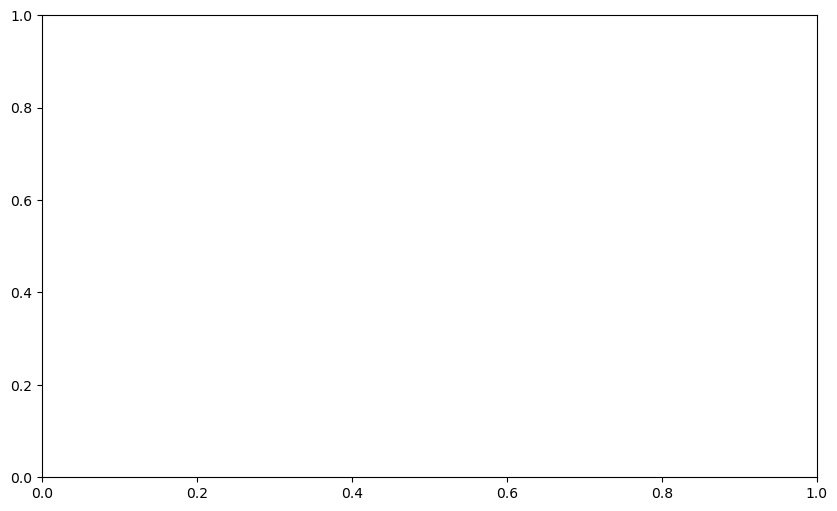

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Load the Doppler data
doppler_data_path = r"C:\Users\Maxim\Documents\03 University\04 Msci Project\Midas\doppler_data\radar_data\radar_data\dkk\0\01\doppler_gt.npy"  # Replace with the correct file path
#doppler_data_path = r"C:\Users\Maxim\OneDrive\Documents\03 University\02 Year5\01 Project\reconstructedDopplerData.npy"
doppler_data = np.load(doppler_data_path)
print(doppler_data.shape)
print(doppler_data[0].max())
print(doppler_data[1][:])


def get_spectograms(dop_dat, t_chunk, frames_per_sec, t_chunk_overlap=None, synthetic=False,zero_pad=False):
    frame_overlap = 1
    if t_chunk_overlap is not None:
        frame_overlap = int(t_chunk_overlap * frames_per_sec)
    frame_chunk = int(t_chunk * frames_per_sec)
    if zero_pad == True:
        zero_padding = np.zeros((32,frame_chunk-1))
        dop_dat_spec = np.hstack((zero_padding,np.transpose(dop_dat)))  
    else:
        dop_dat_spec = np.transpose(dop_dat)
    spectogram = []
    if zero_pad == True:
        for i in range(0,len(dop_dat), frame_overlap):
            spec = dop_dat_spec[:,i:i+frame_chunk]
            if synthetic == True:
                spec = cv2.GaussianBlur(spec,(5,5),0)
            spectogram.append(spec)
    else:
        for i in range(0,len(dop_dat)-frame_chunk, frame_overlap):
            spec = dop_dat_spec[:,i:i+frame_chunk]
            if synthetic == True:
                if zero_pad == True:
                    spec = cv2.GaussianBlur(spec,(5,5),0)
            spectogram.append(spec)
    spectogram = np.array(spectogram)
    return spectogram

doppler_data = get_spectograms(doppler_data.T,3,24)



# Create an intensity map for the Doppler data
plt.figure(figsize=(10, 6))
plt.imshow(doppler_data, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Intensity')
plt.title('Doppler Intensity Map')
plt.xlabel('Time/Frequency Bins')
plt.ylabel('Radial Velocity (m/s)')

num_channels = doppler_data.shape[0]  # Number of sensor channels
y_ticks = np.linspace(0, num_channels - 1, 5)  # Select 5 tick positions
y_labels = np.linspace(-2, 2, 5)  # Corresponding velocity values (-2 to +2)
plt.yticks(y_ticks, [f"{label:.1f} m/s" for label in y_labels])  # Set labels
    
plt.tight_layout()
plt.show()


(178, 32, 72)
(178, 32, 72)


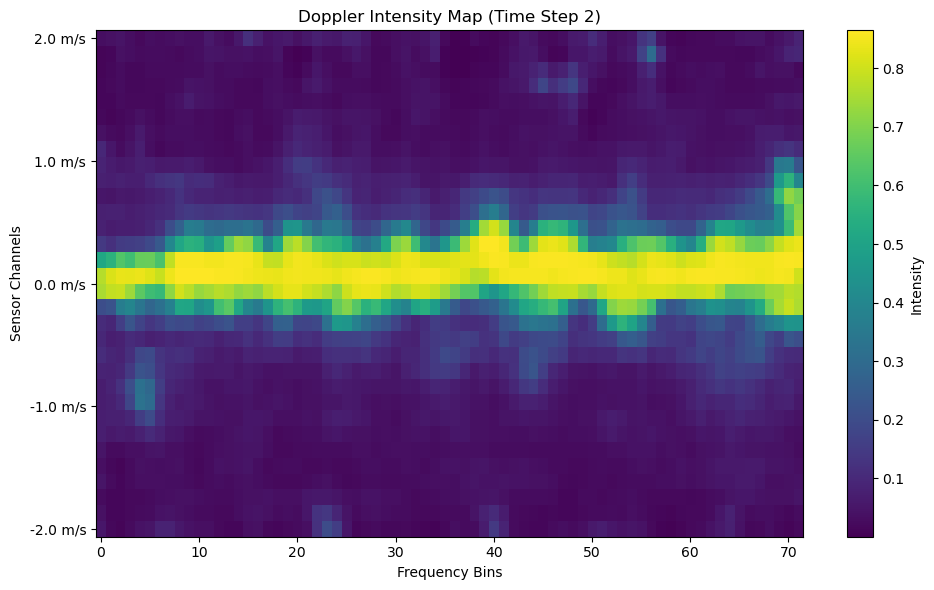

In [3]:
import numpy as np
import matplotlib.pyplot as plt


doppler_data_path = r"C:\Users\Maxim\OneDrive\Documents\03 University\02 Year5\01 Project\rawPredictedOutputV3.npy"
doppler_data = np.load(doppler_data_path)
print(doppler_data.shape)
doppler_data = doppler_data.reshape(178, 32, 72)

print(doppler_data.shape)
#doppler_data.reshape(32,250)
# Select a time slice (e.g., first time step)
time_index = 2  # Change this to visualize other time steps
doppler_slice = doppler_data[time_index]  # Shape (32, 72)

# Create an intensity map for the Doppler data
plt.figure(figsize=(10, 6))
plt.imshow(doppler_slice, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Intensity')
plt.title(f'Doppler Intensity Map (Time Step {time_index})')
plt.xlabel('Frequency Bins')
plt.ylabel('Sensor Channels')

# Set Y-axis labels based on sensor channels
num_channels = doppler_slice.shape[0]  # 32 channels
y_ticks = np.linspace(0, num_channels - 1, 5)  # Select 5 tick positions
y_labels = np.linspace(-2, 2, 5)  # Corresponding velocity values (-2 to +2)
plt.yticks(y_ticks, [f"{label:.1f} m/s" for label in y_labels])  # Set labels

plt.tight_layout()
plt.show()


(32, 250)


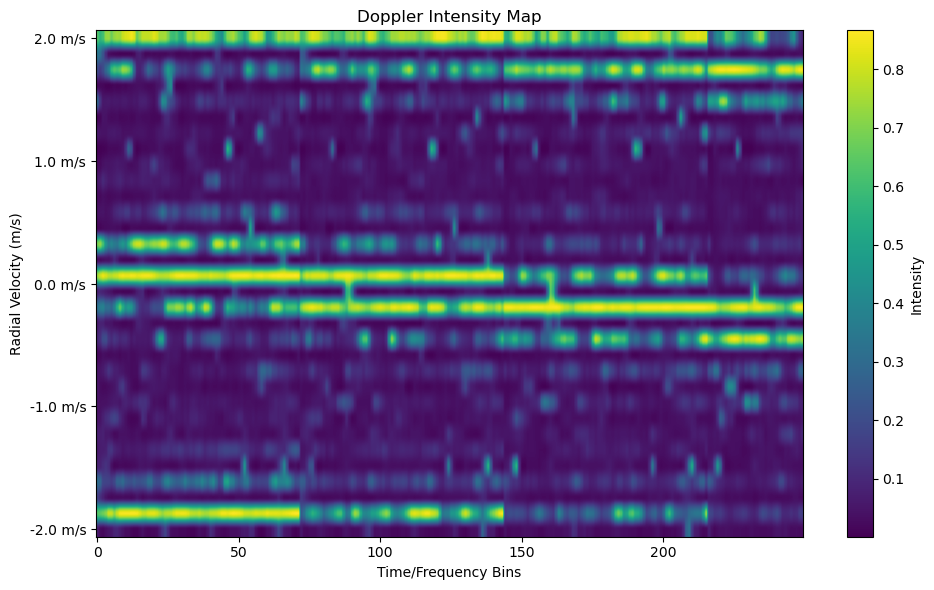

In [2]:
import numpy as np
import matplotlib.pyplot as plt


doppler_data_path = r"C:\Users\Maxim\OneDrive\Documents\03 University\02 Year5\01 Project\reconstructedDopplerDataV2.npy"
doppler_data = np.load(doppler_data_path)
print(doppler_data.shape)


# Create an intensity map for the Doppler data
plt.figure(figsize=(10, 6))
plt.imshow(doppler_data, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Intensity')
plt.title('Doppler Intensity Map')
plt.xlabel('Time/Frequency Bins')
plt.ylabel('Radial Velocity (m/s)')

num_channels = doppler_data.shape[0]  # Number of sensor channels
y_ticks = np.linspace(0, num_channels - 1, 5)  # Select 5 tick positions
y_labels = np.linspace(-2, 2, 5)  # Corresponding velocity values (-2 to +2)
plt.yticks(y_ticks, [f"{label:.1f} m/s" for label in y_labels])  # Set labels
    
plt.tight_layout()
plt.show()


In [24]:
for i in range(0,-40,1):
    print("yes")

In [38]:
import numpy as np

# Step 1: Create example data
original_data = np.array([
    [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],  
    [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],  
    [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]   
])

frame_chunk = 4
frame_overlap = 2

# Step 2: Extract slices into spectogram list
spectogram = []
for i in range(0, original_data.shape[1] - frame_chunk + 1, frame_overlap):
    spectogram.append(original_data[:, i:i+frame_chunk])

spectogram = np.array(spectogram)  # Convert to numpy array
print(f"Extracted spectogram shape: {spectogram.shape}")  # Should be (4, 3, 4)


Extracted spectogram shape: (4, 3, 4)


In [39]:
# Step 3: Initialize empty reconstruction array
reconstructed = np.zeros_like(original_data)
print(spectogram)

# Step 4: Place back each slice without averaging
for idx, spec in enumerate(spectogram):
    print(spec.shape)
    start = idx * frame_overlap
    end = start + frame_chunk
    reconstructed[:, start:end] = spec  # Direct placement
    print(reconstructed)

print("Reconstructed Data:")
print(reconstructed.shape)

# Step 5: Verify correctness
assert np.array_equal(reconstructed, original_data), "Reconstruction failed!"
print("✅ Reconstruction successful!")


[[[ 1  2  3  4]
  [11 12 13 14]
  [21 22 23 24]]

 [[ 3  4  5  6]
  [13 14 15 16]
  [23 24 25 26]]

 [[ 5  6  7  8]
  [15 16 17 18]
  [25 26 27 28]]

 [[ 7  8  9 10]
  [17 18 19 20]
  [27 28 29 30]]]
(3, 4)
[[ 1  2  3  4  0  0  0  0  0  0]
 [11 12 13 14  0  0  0  0  0  0]
 [21 22 23 24  0  0  0  0  0  0]]
(3, 4)
[[ 1  2  3  4  5  6  0  0  0  0]
 [11 12 13 14 15 16  0  0  0  0]
 [21 22 23 24 25 26  0  0  0  0]]
(3, 4)
[[ 1  2  3  4  5  6  7  8  0  0]
 [11 12 13 14 15 16 17 18  0  0]
 [21 22 23 24 25 26 27 28  0  0]]
(3, 4)
[[ 1  2  3  4  5  6  7  8  9 10]
 [11 12 13 14 15 16 17 18 19 20]
 [21 22 23 24 25 26 27 28 29 30]]
Reconstructed Data:
(3, 10)
✅ Reconstruction successful!


(178, 32, 72)
(32, 250)
[0.06700871 0.06401598 0.05247062 0.04675284 0.05005616 0.04517903
 0.04691646 0.07950628 0.15615804 0.15343203 0.1271359  0.09956753
 0.06610293 0.05087009 0.05041077 0.05355799 0.04226859 0.03577659
 0.03344937 0.03896689 0.04659087 0.06102721 0.07939491 0.08939669
 0.08459285 0.09750356 0.08664663 0.0894692  0.06482372 0.03699509
 0.03305512 0.05651203 0.12739709 0.16280077 0.18352644 0.16641136
 0.11183556 0.08800153 0.08534023 0.10298379 0.10604314 0.07441828
 0.08123523 0.07959635 0.11932818 0.27365813 0.157001   0.13035074
 0.15466756 0.12818269 0.17932421 0.21326792 0.20731209 0.12142416
 0.1140855  0.15478729 0.24507387 0.34659344 0.2247539  0.21492255
 0.18885334 0.1806152  0.23427662 0.09589155 0.04079043 0.0354065
 0.04014534 0.07102489 0.18767881 0.21120097 0.10783329 0.07370219
 0.05117092 0.04787021 0.02755701 0.01979239 0.01743582 0.01686536
 0.02614884 0.03024136 0.0391323  0.0382819  0.03927832 0.05204303
 0.05769047 0.08237756 0.13177972 0.093

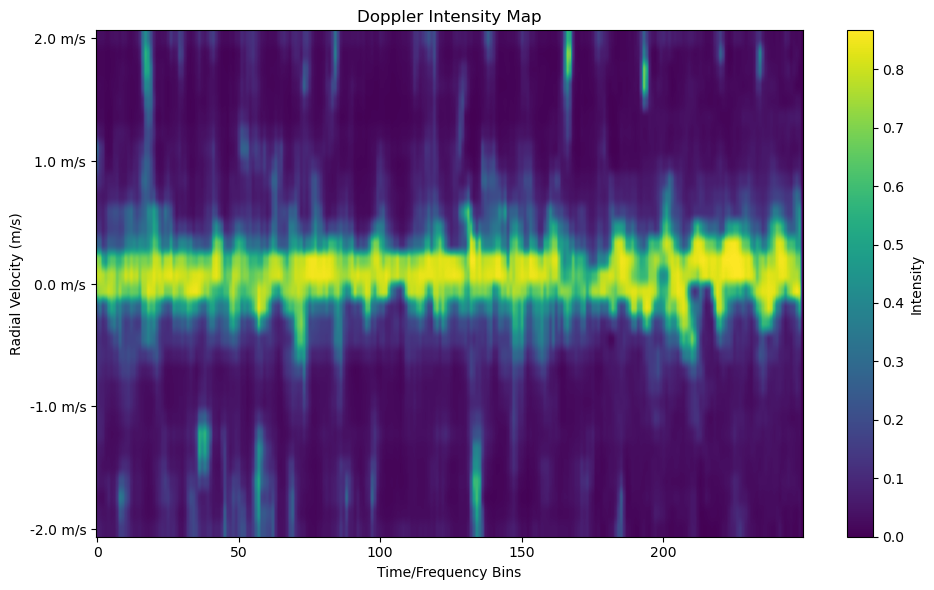

In [62]:
import numpy as np

doppler_data_path = r"C:\Users\Maxim\OneDrive\Documents\03 University\02 Year5\01 Project\rawPredictedOutputV3.npy"
doppler_data = np.load(doppler_data_path)
print(doppler_data.shape)

# Initialize an empty array for reconstruction
reconstructed = np.zeros((32, 250))  # (250, 32)
frame_chunk = 72
frame_overlap = 1

# Reverse iteration: place back each extracted segment
for idx, spec in enumerate(doppler_data):
    start = idx * frame_overlap
    end = start + frame_chunk
    reconstructed[:, start:end] = spec  # Directly placing it back
    
reconstructed = reconstructed
print(reconstructed.shape)  # Should match (250, 32)
print(reconstructed[0])


# Create an intensity map for the Doppler data
plt.figure(figsize=(10, 6))
plt.imshow(reconstructed, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Intensity')
plt.title('Doppler Intensity Map')
plt.xlabel('Time/Frequency Bins')
plt.ylabel('Radial Velocity (m/s)')

num_channels = reconstructed.shape[0]  # Number of sensor channels
y_ticks = np.linspace(0, num_channels - 1, 5)  # Select 5 tick positions
y_labels = np.linspace(-2, 2, 5)  # Corresponding velocity values (-2 to +2)
plt.yticks(y_ticks, [f"{label:.1f} m/s" for label in y_labels])  # Set labels
    
plt.tight_layout()
plt.show()


In [60]:
##Testing that the reconstruction process works:

def get_spectograms(dop_dat, t_chunk, frames_per_sec, t_chunk_overlap=None, synthetic=False,zero_pad=False):
	frame_overlap = 1
	if t_chunk_overlap is not None:
		frame_overlap = int(t_chunk_overlap * frames_per_sec)
	frame_chunk = int(t_chunk * frames_per_sec)
	if zero_pad == True:
		zero_padding = np.zeros((32,frame_chunk-1))
		dop_dat_spec = np.hstack((zero_padding,np.transpose(dop_dat)))
	else:
		dop_dat_spec = np.transpose(dop_dat)
	spectogram = []
	if zero_pad == True:
		for i in range(0,len(dop_dat), frame_overlap):
			spec = dop_dat_spec[:,i:i+frame_chunk]
			if synthetic == True:
					spec = cv2.GaussianBlur(spec,(5,5),0)
			spectogram.append(spec)
	else:
		for i in range(0,len(dop_dat)-frame_chunk +1, frame_overlap):
			
			spec = dop_dat_spec[:,i:i+frame_chunk]
			if synthetic == True:
				if zero_pad == True:
					spec = cv2.GaussianBlur(spec,(5,5),0)
			spectogram.append(spec)
	spectogram = np.array(spectogram)
	return spectogram


doppler_data_path = r"C:\Users\Maxim\Documents\03 University\04 Msci Project\Midas\doppler_data\radar_data\radar_data\dkk\0\01\doppler_gt.npy"
real_data = np.load(doppler_data_path)

doppler_data = get_spectograms(real_data.T, 3, 24)

# Initialize an empty array for reconstruction
reconstructed = np.zeros((32, 250))  # (250, 32)
frame_chunk = 72
frame_overlap = 1

# Reverse iteration: place back each extracted segment
for idx, spec in enumerate(doppler_data):
    start = idx * frame_overlap
    end = min(start + frame_chunk, 250)  # Clip to avoid exceeding size
    reconstructed[:, start:end] = spec[:, : end - start]  # Slice properly
    
reconstructed = reconstructed
print(reconstructed.shape)  # Should match (250, 32)

print(real_data[0]-reconstructed[0])

(32, 250)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [26]:
from PIL import Image
import numpy as np

# Load images
image1 = Image.open("image1.jpg")
image2 = Image.open("image2.jpg")
image3 = Image.open("image3.jpg")

# Resize images to the same width (optional, if needed)
width = min(image1.width, image2.width, image3.width)
image1 = image1.resize((width, image1.height))
image2 = image2.resize((width, image2.height))
image3 = image3.resize((width, image3.height))

# Convert images to NumPy arrays
img_array1 = np.array(image1)
img_array2 = np.array(image2)
img_array3 = np.array(image3)

# Stack images vertically
stacked_image = np.vstack([img_array1, img_array2, img_array3])

# Convert back to an image
stacked_pil_image = Image.fromarray(stacked_image)

# Save or show the result
stacked_pil_image.save("stacked_output.jpg")
stacked_pil_image.show()


FileNotFoundError: [Errno 2] No such file or directory: 'image1.jpg'

In [44]:
import os
from PIL import Image
import numpy as np


def split_filenames(input_dir):
    files_real, files_coarse, files_reconstructed = [], [], []
    
    for file in os.listdir(input_dir):
        if not os.path.isfile(os.path.join(input_dir, file)):
            continue  # Skip directories
        
        file_lower = file.lower()
        if file_lower.startswith("vis_real"):
            files_real.append(file)
        elif file_lower.startswith("vis_coarse"):
            files_coarse.append(file)
        else:
            files_reconstructed.append(file)
    
    return files_real, files_coarse, files_reconstructed

# Example usage
input_directory = r"C:\Users\Maxim\Documents\03 University\04 Msci Project\dopplerVisualisation"
files_real, files_coarse, files_reconstructed = split_filenames(input_directory)
output_directory = r"C:\Users\Maxim\Documents\03 University\04 Msci Project\dopplerVisualisation\stacked"
for i in range(len(files_real)):
    splitName = files_real[i].split("_")[2:]
    splitName[-1] = splitName[-1][:-4]
    real = os.path.join(input_directory,files_real[i])
    coarse = os.path.join(input_directory,files_coarse[i])
    reconstructed = os.path.join(input_directory,files_reconstructed[i])
    outputPath = os.path.join(output_directory,f"stacked__{splitName[0]}_{splitName[1]}_{splitName[2]}.png")
    print(outputPath)
    # Load images
    image1 = Image.open(coarse)
    image2 = Image.open(reconstructed)
    image3 = Image.open(real)

    # Resize images to the same width (optional, if needed)
    width = min(image1.width, image2.width, image3.width)
    image1 = image1.resize((width, image1.height))
    image2 = image2.resize((width, image2.height))
    image3 = image3.resize((width, image3.height))

    # Convert images to NumPy arrays
    img_array1 = np.array(image1)
    img_array2 = np.array(image2)
    img_array3 = np.array(image3)

    # Stack images vertically
    stacked_image = np.vstack([img_array1, img_array2, img_array3])

    # Convert back to an image
    stacked_pil_image = Image.fromarray(stacked_image)

    # Save or show the result
    #stacked_pil_image.save(outputPath)
    #stacked_pil_image.show()



['dkk', '0', '01.png']
C:\Users\Maxim\Documents\03 University\04 Msci Project\dopplerVisualisation\stacked\stacked__dkk_0_01.png
['dkk', '0', '02.png']
C:\Users\Maxim\Documents\03 University\04 Msci Project\dopplerVisualisation\stacked\stacked__dkk_0_02.png
['dkk', '0', '03.png']
C:\Users\Maxim\Documents\03 University\04 Msci Project\dopplerVisualisation\stacked\stacked__dkk_0_03.png
['dkk', '0', '04.png']
C:\Users\Maxim\Documents\03 University\04 Msci Project\dopplerVisualisation\stacked\stacked__dkk_0_04.png
['dkk', '0', '05.png']
C:\Users\Maxim\Documents\03 University\04 Msci Project\dopplerVisualisation\stacked\stacked__dkk_0_05.png
['dkk', '0', '06', 'r.png']
C:\Users\Maxim\Documents\03 University\04 Msci Project\dopplerVisualisation\stacked\stacked__dkk_0_06.png
['dkk', '0', '07.png']
C:\Users\Maxim\Documents\03 University\04 Msci Project\dopplerVisualisation\stacked\stacked__dkk_0_07.png
['dkk', '0', '08.png']
C:\Users\Maxim\Documents\03 University\04 Msci Project\dopplerVisuali

['zzh', '90', '09', 'r.png']
C:\Users\Maxim\Documents\03 University\04 Msci Project\dopplerVisualisation\stacked\stacked__zzh_90_09.png
['zzh', '90', '10.png']
C:\Users\Maxim\Documents\03 University\04 Msci Project\dopplerVisualisation\stacked\stacked__zzh_90_10.png
['zzh', '90', '11.png']
C:\Users\Maxim\Documents\03 University\04 Msci Project\dopplerVisualisation\stacked\stacked__zzh_90_11.png


In [51]:
import os
from PIL import Image
import numpy as np


def split_filenames(input_dir):
    files_real, files_coarse, files_reconstructed = [], [], []
    
    for file in os.listdir(input_dir):
        if not os.path.isfile(os.path.join(input_dir, file)):
            continue  # Skip directories
        
        file_lower = file.lower()
        if file_lower.startswith("vis_real"):
            files_real.append(file)
        elif file_lower.startswith("vis_coarse"):
            files_coarse.append(file)
        else:
            files_reconstructed.append(file)
    
    return files_real, files_coarse, files_reconstructed

# Example usage
input_directory = r"C:\Users\Maxim\Documents\03 University\04 Msci Project\dopplerVisualisation(Inital)"
files_real, files_coarse, files_reconstructed = split_filenames(input_directory)
output_directory = r"C:\Users\Maxim\Documents\03 University\04 Msci Project"

def StackImages(i):
    splitName = files_real[i].split("_")[2:]
    splitName[-1] = splitName[-1][:-4]
    real = os.path.join(input_directory,files_real[i])
    coarse = os.path.join(input_directory,files_coarse[i])
    reconstructed = os.path.join(input_directory,files_reconstructed[i])
    outputPath = os.path.join(output_directory,f"stacked__{splitName[0]}_{splitName[1]}_{splitName[2]}.png")
    print(outputPath)
    # Load images
    image1 = Image.open(coarse)
    image2 = Image.open(reconstructed)
    image3 = Image.open(real)

    # Resize images to the same width (optional, if needed)
    width = min(image1.width, image2.width, image3.width)
    image1 = image1.resize((width, image1.height))
    image2 = image2.resize((width, image2.height))
    image3 = image3.resize((width, image3.height))

    # Convert images to NumPy arrays
    img_array1 = np.array(image1)
    img_array2 = np.array(image2)
    img_array3 = np.array(image3)

    # Stack images vertically
    stacked_image = np.hstack([img_array1, img_array2, img_array3])

    # Convert back to an image
    stacked_pil_image = Image.fromarray(stacked_image)

    # Save or show the result
    stacked_pil_image.save(outputPath)
    stacked_pil_image.show()

StackImages(3)


C:\Users\Maxim\Documents\03 University\04 Msci Project\stacked__dkk_0_04.png


In [ ]:
filepath = f""
